# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Fall 2019

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [55]:
import cv2
import numpy as np
from numpy.linalg import svd, inv

%matplotlib inline
from matplotlib import pyplot as plt

In [56]:
pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
pts = pts.reshape((-1,1,2))
print(pts)

[[[10  5]]

 [[20 30]]

 [[70 20]]

 [[50 10]]]


In [57]:
import PIL.Image as Image


In [58]:
# images location
im1 = './images/input/my_frames1/f0220.jpg'
im2 = './images/input/my_frames1/f0270.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1) # float32, 0.0-1.0
im2 = cv2.imread(im2)
# im1.resize((480,320),Image.ANTIALIAS)
print(im1.shape[0],im1.shape[1],im1.shape[2])
img_rows = im1.shape[0] # 1920
img_cols = im1.shape[1] # 1080


1920 1080 3


In [67]:
def auto_homography(Ia,Ib, homography_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    # kp_a is keypoints List and des_a is descriptors List
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)
#     print('---TEST values in matches, which is list of elements(a,b)---')
#     print(matches[0])
#     print(matches[0][0].distance)
#     print(matches[0][1].distance)
    
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    
    numMatches = int(len(good)) # numMatches = 215
    matches = good 
    
    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
#     print('---TEST 3*215 point---')
#     print(Xa[:,0][0:2])
#     print(Xa[:,0])
    pts1_good = np.ones((3,4))
    pts2_good = np.ones((3,4))
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    
    H = np.zeros((3,3))
    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]

        H_t = homography_func(pts1, pts2)
#         H_t = computeHomography(pts1, pts2) # edit helper code below (computeHomography)
        # pts1 = 3xN matrix and N = 4

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]
        
        ok_t = np.sqrt(du**2 + dv**2) < 1  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
            pts1_good = pts1
            pts2_good = pts2
#     print(pts1_good)
#     print(pts2_good)
    print('best score: {:02f}'.format(best_score))
    
# # Check that your homography is correct by plotting four points that form a square in frame 270 
#     # use as the four corners to draw the polylines
#     con_pts1 = np.zeros((4,2),np.int32)
#     con_pts2 = np.zeros((4,2),np.int32)
    
#     for i in range (4):
# #         print("point %d Xa"%(i),pts1_good[:,i])
# #         print("point %d Xb"%(i),pts2_good[:,i])  
# #         Xb_ = np.dot(H, Xa)
# #         print("point %d Xb_"%(i),Xb_[:,i])
# #         print(Xb_[:,i]/Xb_[2,i])
#         con_pts1[i] = pts1_good[0:2,i]
#         con_pts2[i] = pts2_good[0:2,i]
# #         print(con_pts1[i])
# #         print(con_pts2[i])
# #     A[[i, j], :] = A[[j, i], :] # 实现了第i行与第j行的互换
#     im1_RGB2 = cv2.cvtColor(Ia,cv2.COLOR_BGR2RGB)
#     im2_RGB2 = cv2.cvtColor(Ib,cv2.COLOR_BGR2RGB)
#     con_pts1[[0, 2], :] = con_pts1[[2, 0], :]
#     con_pts2[[0, 2], :] = con_pts2[[2, 0], :]
    
# #   for draw rectangular  im1_RGB2 = cv2.rectangle(im1_RGB2,(100,100),(200,200),(255,0,0),3)
# #     pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
#     con_pts1 = con_pts1.reshape((-1,1,2))
#     con_pts2 = con_pts2.reshape((-1,1,2))
# #     print("--------")
# #     print(con_pts1)
# #     print(con_pts2)
#     im1_RGB2 = cv2.polylines(im1_RGB2,[con_pts1],True,(255,0,0),thickness = 2,lineType = 8)
#     im2_RGB2 = cv2.polylines(im2_RGB2,[con_pts2],True,(255,0,0),thickness = 2,lineType = 8)
    
#     plt.imshow(im1_RGB2)
#     plt.show()
    
#     plt.imshow(im2_RGB2)
#     plt.show()
    
#     # Optionally, you may want to re-estimate H based on inliers

    return H

In [68]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates.  N is 4.
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    
    dimen, num = pts1.shape
    A = np.zeros((2*num, 9), dtype = np.float32)
    
    for i in range (0, num):
        # p_prime = w*[u_prime,v_prime,1]
        # p = [u,v,1]
        p_prime = pts2[:,i]
        u_prime = p_prime[0]/p_prime[2]
        v_prime = p_prime[1]/p_prime[2]
        
        p = pts1[:,i]
        u = p[0]/p[2]
        v = p[1]/p[2]
        A[i*2,:] = [-u,-v,-1,0,0,0,u*u_prime, v*u_prime, u_prime]
        A[i*2+1,:] = [0,0,0,-u,-v,-1,u*v_prime, v*v_prime, v_prime]
    U,S,Vt = svd(A)
    h = Vt[-1,:]
    H = np.reshape(h, (3, 3))
    
#     std1_u = np.std(pts1[1,:])
#     std1_v =  np.std(pts1[2,:])
#     mean1_u = np.mean(pts1[1,:])
#     mean1_v = np.mean(pts1[2,:]) 
#     T1 = np.matrix([[1/std1_u, 0, 0],[0, 1/std1_v, 0],[0, 0, 1]]) * np.matrix([[1,0,-mean1_u],[0,1,-mean1_v],[0,0,1]])
    
#     std2_u = np.std(pts2[1,:])
#     std2_v = np.std(pts2[2,:])
#     mean2_u = np.mean(pts2[1,:])
#     mean2_v = np.mean(pts2[2,:]) 
#     T2 = np.matrix([[1/std2_u, 0, 0],[0, 1/std2_v, 0],[0, 0, 1]]) * np.matrix([[1,0,-mean2_u],[0,1,-mean2_v],[0,0,1]])
#     H = T2/H_n * T1
    return H


best score: 414.000000


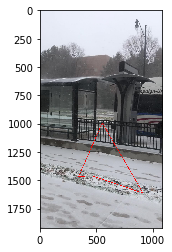

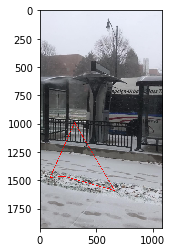

In [69]:
H = auto_homography(im1,im2, computeHomography)

'It is important to change color from BGR to RGB'

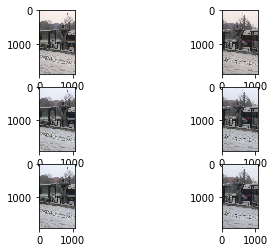

In [62]:
im1_path = './images/input/my_frames1/f0220.jpg'
im2_path = './images/input/my_frames1/f0270.jpg'
im1_cv2 = cv2.imread(im1_path) # uint 0-255
im2_cv2 = cv2.imread(im2_path)

im1_RGB = cv2.cvtColor(im1_cv2,cv2.COLOR_BGR2RGB)
im2_RGB = cv2.cvtColor(im2_cv2,cv2.COLOR_BGR2RGB)

im1_plt = im1_RGB.astype(np.float32)/255
im2_plt = im2_RGB.astype(np.float32)/255


# im1 = cv2.imread(im1_path,cv2.COLOR_BGR2RGB)
# im2 = cv2.imread(im2_path,cv2.COLOR_BGR2RGB)
# Load an color image in grayscale
# im1 = plt.imread(im1) # float32, 0.0-1.0
# im2 = plt.imread(im2)

fig, axes = plt.subplots(3,2)
axes[0,0].imshow(im1_cv2)
axes[0,1].imshow(im2_cv2)
axes[1,0].imshow(im1_RGB)
axes[1,1].imshow(im2_RGB)
axes[2,0].imshow(im1_plt)
axes[2,1].imshow(im2_plt)
"It is important to change color from BGR to RGB"

[[1.00e+00 0.00e+00 1.46e+03]
 [0.00e+00 1.00e+00 1.40e+02]
 [0.00e+00 0.00e+00 1.00e+00]]


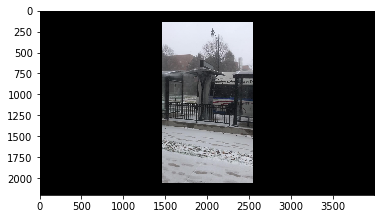

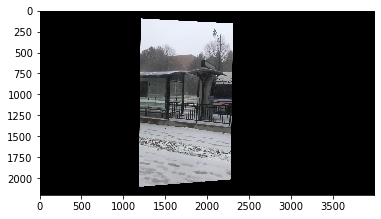

method1


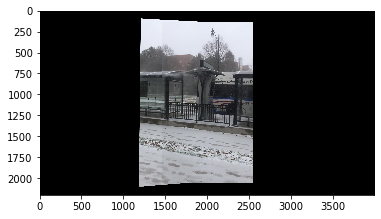

In [63]:
cols = 4000
rows = 2200
# 360*480
# pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
# dst = cv2.perspectiveTransform(pts, H)
H_transition = np.identity(3)
H_transition[0,2] = (cols-img_cols)/2
H_transition[1,2] = (rows-img_rows)/2
print(H_transition)
# Xb_ = np.dot(H, im1_plt) # project points from first image to second using H
# du = Xb_[0,:]/Xb_[2,:]
# img_warped = cv2.warpPerspective(img, H_t.dot(H), (output_width, output_height))

img_warped_270 = cv2.warpPerspective(im2_plt,H_transition,(cols, rows))
img_warped_0 = cv2.warpPerspective(im1_plt, np.dot(H_transition, H), (cols, rows))
# img_warped3 = cv2.warpPerspective(img_warped2, H_transition, (w, h))

plt.imshow(img_warped_270)
plt.show()
plt.imshow(img_warped_0)
plt.show()
#  method 1
print("method1")
result = img_warped_270
for i in range(0,rows):
    for j in range(0,cols):
        if (result[i,j].sum() == 0) and (img_warped_0[i,j].sum() != 0):
            result[i,j] = img_warped_0[i,j]
plt.imshow(result)
plt.show()

In [ ]:
'''
#  method 2
print("method2")
for col in range(0, cols):
    if img_warped_270[:, col].any() and img_warped_0[:, col].any():
        left = col
        break
for col in range(cols-1, 0, -1):
    if img_warped_270[:, col].any() and img_warped_0[:, col].any():
        right = col
        break
srcImg = img_warped_270
warpImg = img_warped_0
res = np.zeros([rows, cols, 3], np.float32)

for row in range(0, rows):
    for col in range(0, cols):
        if not srcImg[row, col].any():
            res[row, col] = warpImg[row, col]
        elif not warpImg[row, col].any():
            res[row, col] = srcImg[row, col]
        else:
            srcImgLen = float(abs(col - right))
            testImgLen = float(abs(col - left))
            alpha = srcImgLen / (srcImgLen + testImgLen)
            res[row, col] = np.clip(srcImg[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)
plt.imshow(res)
plt.show()
'''

### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [11]:
import cv2
import numpy as np
import utils

In [12]:
def warpped(result,img1,img2,H):
    # img2 = H*img1
    rows, cols, c = result.shape
#     cols = 1200
#     rows = 500
    img_warped = cv2.warpPerspective(img1, np.dot(H_transition, H), (cols, rows))
    return utils.blendImages(img_warped, result)
#     the following is written by myself instead of using utils.blendImages
#     for i in range(0,rows):
#         for j in range(0,cols):
#             if (result[i,j].sum() == 0) and (img_warped[i,j].sum() != 0):
#                 result[i,j] = img_warped[i,j]
#     return 0

best score: 515.000000
best score: 388.000000
best score: 322.000000
best score: 253.000000


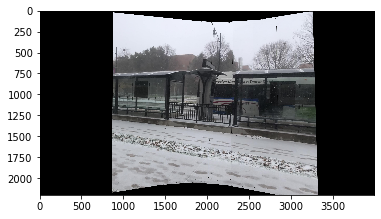

In [13]:
master_frames =[170,220,270,320,370]
reference_frame = 270
reference_idx = master_frames.index(reference_frame)
im1_path = './images/input/my_frames1/f0170.jpg'
im2_path = './images/input/my_frames1/f0220.jpg'
im3_path = './images/input/my_frames1/f0270.jpg'
im4_path = './images/input/my_frames1/f0320.jpg'
im5_path = './images/input/my_frames1/f0370.jpg'
im1_cv2 = cv2.imread(im1_path) # float32, 0.0-1.0
im2_cv2 = cv2.imread(im2_path)
im3_cv2 = cv2.imread(im3_path)
im4_cv2 = cv2.imread(im4_path)
im5_cv2 = cv2.imread(im5_path)

im1_RGB = cv2.cvtColor(im1_cv2,cv2.COLOR_BGR2RGB)
im2_RGB = cv2.cvtColor(im2_cv2,cv2.COLOR_BGR2RGB)
im3_RGB = cv2.cvtColor(im3_cv2,cv2.COLOR_BGR2RGB)
im4_RGB = cv2.cvtColor(im4_cv2,cv2.COLOR_BGR2RGB)
im5_RGB = cv2.cvtColor(im5_cv2,cv2.COLOR_BGR2RGB)

# fig, axes = plt.subplots(1,5)
# axes[0].imshow(im1_RGB)
# axes[1].imshow(im2_RGB)
# axes[2].imshow(im3_RGB)
# axes[3].imshow(im4_RGB)
# axes[4].imshow(im5_RGB)

H12 = auto_homography(im1_cv2,im2_cv2, computeHomography)
H23 = auto_homography(im2_cv2,im3_cv2, computeHomography)
H43 = auto_homography(im4_cv2,im3_cv2, computeHomography)
H54 = auto_homography(im5_cv2,im4_cv2, computeHomography)


H13 = np.dot(H23,H12)
H53 = np.dot(H43,H54)
cols = 4000
rows = 2200
# 1920*1080
H_transition = np.identity(3)
H_transition[0,2] = (cols-img_cols)/2
H_transition[1,2] = (rows-img_rows)/2

result = cv2.warpPerspective(im1_RGB ,np.dot(H_transition, H13),(cols, rows))

warpped(result,im2_RGB,im3_RGB,H23)
warpped(result,im3_RGB,im3_RGB,np.identity(3))
warpped(result,im4_RGB,im3_RGB,H43)
warpped(result,im5_RGB,im3_RGB,H53)

# img_warped_0 = cv2.warpPerspective(im1_plt, np.dot(H_transition, H), (cols, rows))
# img_warped3 = cv2.warpPerspective(img_warped2, H_transition, (w, h))

plt.imshow(result)
plt.show()

### Part 3: Map the video to the reference plane

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

# import utils

In [6]:
dir_frames = 'images/input/my_frames1'
filenames = []
filesinfo = os.scandir(dir_frames)
filesinfo

In [7]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
filenames

['images/input/my_frames1/f0001.jpg',
 'images/input/my_frames1/f0002.jpg',
 'images/input/my_frames1/f0003.jpg',
 'images/input/my_frames1/f0004.jpg',
 'images/input/my_frames1/f0005.jpg',
 'images/input/my_frames1/f0006.jpg',
 'images/input/my_frames1/f0007.jpg',
 'images/input/my_frames1/f0008.jpg',
 'images/input/my_frames1/f0009.jpg',
 'images/input/my_frames1/f0010.jpg',
 'images/input/my_frames1/f0011.jpg',
 'images/input/my_frames1/f0012.jpg',
 'images/input/my_frames1/f0013.jpg',
 'images/input/my_frames1/f0014.jpg',
 'images/input/my_frames1/f0015.jpg',
 'images/input/my_frames1/f0016.jpg',
 'images/input/my_frames1/f0017.jpg',
 'images/input/my_frames1/f0018.jpg',
 'images/input/my_frames1/f0019.jpg',
 'images/input/my_frames1/f0020.jpg',
 'images/input/my_frames1/f0021.jpg',
 'images/input/my_frames1/f0022.jpg',
 'images/input/my_frames1/f0023.jpg',
 'images/input/my_frames1/f0024.jpg',
 'images/input/my_frames1/f0025.jpg',
 'images/input/my_frames1/f0026.jpg',
 'images/inp

In [8]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
# rows, cols, 3 for a frame
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)
# 900, rows, cols, 3 for all frames

In [9]:
# im2_cv2 = cv2.imread(im2_path)
# im2_RGB = cv2.cvtColor(im2_cv2,cv2.COLOR_BGR2RGB)
# im2_plt = im2_RGB.astype(np.float32)/255  !!! (value/255.0) instead of 255
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0

In [10]:
def auto_homography(Ia,Ib, homography_func=None, normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    # kp_a is keypoints List and des_a is descriptors List
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)
#     print('---TEST values in matches, which is list of elements(a,b)---')
#     print(matches[0])
#     print(matches[0][0].distance)
#     print(matches[0][1].distance)
    
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    
    numMatches = int(len(good)) # numMatches = 215
    matches = good 
    
    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
#     print('---TEST 3*215 point---')
#     print(Xa[:,0][0:2])
#     print(Xa[:,0])
    pts1_good = np.ones((3,4))
    pts2_good = np.ones((3,4))
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    
    H = np.zeros((3,3))
    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]

        H_t = homography_func(pts1, pts2, normalization_func)
#         H_t = computeHomography(pts1, pts2) # edit helper code below (computeHomography)
        # pts1 = 3xN matrix and N = 4

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]
        
        ok_t = np.sqrt(du**2 + dv**2) < 1  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
            pts1_good = pts1
            pts2_good = pts2
#     print(pts1_good)
#     print(pts2_good)
    print('best score: {:02f}'.format(best_score))
    
# # Check that your homography is correct by plotting four points that form a square in frame 270 
#     # use as the four corners to draw the polylines
#     con_pts1 = np.zeros((4,2),np.int32)
#     con_pts2 = np.zeros((4,2),np.int32)
    
#     for i in range (4):
# #         print("point %d Xa"%(i),pts1_good[:,i])
# #         print("point %d Xb"%(i),pts2_good[:,i])  
# #         Xb_ = np.dot(H, Xa)
# #         print("point %d Xb_"%(i),Xb_[:,i])
# #         print(Xb_[:,i]/Xb_[2,i])
#         con_pts1[i] = pts1_good[0:2,i]
#         con_pts2[i] = pts2_good[0:2,i]
# #         print(con_pts1[i])
# #         print(con_pts2[i])
# #     A[[i, j], :] = A[[j, i], :] # 实现了第i行与第j行的互换
#     im1_RGB2 = cv2.cvtColor(Ia,cv2.COLOR_BGR2RGB)
#     im2_RGB2 = cv2.cvtColor(Ib,cv2.COLOR_BGR2RGB)
#     con_pts1[[0, 2], :] = con_pts1[[2, 0], :]
#     con_pts2[[0, 2], :] = con_pts2[[2, 0], :]
    
# #   for draw rectangular  im1_RGB2 = cv2.rectangle(im1_RGB2,(100,100),(200,200),(255,0,0),3)
# #     pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
#     con_pts1 = con_pts1.reshape((-1,1,2))
#     con_pts2 = con_pts2.reshape((-1,1,2))
# #     print("--------")
# #     print(con_pts1)
# #     print(con_pts2)
#     im1_RGB2 = cv2.polylines(im1_RGB2,[con_pts1],True,(255,0,0),thickness = 2,lineType = 8)
#     im2_RGB2 = cv2.polylines(im2_RGB2,[con_pts2],True,(255,0,0),thickness = 2,lineType = 8)
    
#     plt.imshow(im1_RGB2)
#     plt.show()
    
#     plt.imshow(im2_RGB2)
#     plt.show()
    
#     # Optionally, you may want to re-estimate H based on inliers

    return H

In [11]:
def computeHomography(pts1, pts2, normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates.  N is 4.
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    
    dimen, num = pts1.shape
    A = np.zeros((2*num, 9), dtype = np.float32)
    
    for i in range (0, num):
        # p_prime = w*[u_prime,v_prime,1]
        # p = [u,v,1]
        p_prime = pts2[:,i]
        u_prime = p_prime[0]/p_prime[2]
        v_prime = p_prime[1]/p_prime[2]
        
        p = pts1[:,i]
        u = p[0]/p[2]
        v = p[1]/p[2]
        A[i*2,:] = [-u,-v,-1,0,0,0,u*u_prime, v*u_prime, u_prime]
        A[i*2+1,:] = [0,0,0,-u,-v,-1,u*v_prime, v*v_prime, v_prime]
    U,S,Vt = svd(A)
    h = Vt[-1,:]
    H = np.reshape(h, (3, 3))
    
#     std1_u = np.std(pts1[1,:])
#     std1_v =  np.std(pts1[2,:])
#     mean1_u = np.mean(pts1[1,:])
#     mean1_v = np.mean(pts1[2,:]) 
#     T1 = np.matrix([[1/std1_u, 0, 0],[0, 1/std1_v, 0],[0, 0, 1]]) * np.matrix([[1,0,-mean1_u],[0,1,-mean1_v],[0,0,1]])
    
#     std2_u = np.std(pts2[1,:])
#     std2_v = np.std(pts2[2,:])
#     mean2_u = np.mean(pts2[1,:])
#     mean2_v = np.mean(pts2[2,:]) 
#     T2 = np.matrix([[1/std2_u, 0, 0],[0, 1/std2_v, 0],[0, 0, 1]]) * np.matrix([[1,0,-mean2_u],[0,1,-mean2_v],[0,0,1]])
#     H = T2/H_n * T1
    return H


In [49]:
def projectImage(frames, sourceFrameIndex, referenceFrameIndex,
                 pastHomographies, originTranslations, xrange=4000,
                 yrange=2200, overlapThreshold=40000, errorThreshold=4e-4,
                 numKeyframes=3, checkAllKeyframes=0, auto_H_func=None,
                 homography_func=None, normalization_func=None):
    '''
    Input:
        - frames: 4D array of frames
        - sourceFrameIndex: index of the frame to be projected
        - referenceFrameIndex: index of the frame to be projected to
        - pastHomographies: 2D cell array caching previously computed
          homographies from every frame to every other frame
        - xrange, yrange: dimensions of the output image
        - overlapThreshold: sufficient number of pixels overlapping between
          projected source and reference frames to ensure good homography
        - errorThreshold: acceptable error for good homography
        - numKeyframes: number of equidistant keyframes between source and
          reference frame to be visited in search of better homography
        - checkAllKeyframes: 0 if algorithms breaks after first better
          homography is found, 1 if all keyframes are to be visited

    Output:
        - bestProjectedImage: source frame optimally projected onto reference
          frame using reestimation of homography based on closest-frame search
          and using closest-frame homography as
    '''
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# cols = 4000
# rows = 2200
# # 1920*1080
# H_transition = np.identity(3)
# H_transition[0,2] = (cols-img_cols)/2
# H_transition[1,2] = (rows-img_rows)/2
        
    H_transition = np.identity(3)
    H_transition[0,2] = (xrange-img_cols)/2
    H_transition[1,2] = (yrange-img_rows)/2

    print("once")
    numFrames = frames.shape[0]
    _, referenceTransform, ref_origin_coord = transformImage(frames, referenceFrameIndex, referenceFrameIndex, pastHomographies, xrange, yrange, auto_H_func, homography_func, normalization_func)
    _, sourceTransform, src_origin_coord = transformImage(frames, sourceFrameIndex, referenceFrameIndex, pastHomographies, xrange, yrange, auto_H_func, homography_func, normalization_func)
    _, err = computeOverlap(sourceTransform, src_origin_coord, referenceTransform, ref_origin_coord, overlapThreshold)
    originTranslations[sourceFrameIndex] = src_origin_coord
    
    
    x_min, y_min = originTranslations[0]
    # Translation matrix
    t = [-x_min, -y_min]
    H_t = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]], dtype=np.float32)
    # Dot product of translation matrix and homography
    pastHomographies[sourceFrameIndex, referenceFrameIndex] = H_t.dot(pastHomographies[sourceFrameIndex, referenceFrameIndex])

#     projectedImage = cv2.warpPerspective((frames[sourceFrameIndex]*255).astype(np.uint8),
#                                          pastHomographies[sourceFrameIndex, referenceFrameIndex],
#                                          (xrange, yrange))
    projectedImage = cv2.warpPerspective((frames[sourceFrameIndex]*255).astype(np.uint8),
                                         H_transition.dot(pastHomographies[sourceFrameIndex, referenceFrameIndex]),
                                         (xrange, yrange))
   
    
    if err > errorThreshold:
        print('Finding better homography...')
        increment = floor(((referenceFrameIndex - sourceFrameIndex) - 1) / (numKeyframes + 1))
        keyframeIndex = sourceFrameIndex + increment  # frame being used to find better homography from source to reference
#         increment = 10
#         keyframeIndex = 130
        
        found = 0
        counter = 0
        bestHomography = np.eye(3)  # initialize H as identity

        while counter < numKeyframes and keyframeIndex < numFrames and keyframeIndex > 0:

            # compute homography and projected image from keyframe to
            # reference frame
            H2, keyframeTransform, keyframe_origin_coord = transformImage(frames, keyframeIndex, referenceFrameIndex, pastHomographies, xrange, yrange, auto_H_func, homography_func, normalization_func)
            a, error1 = computeOverlap(keyframeTransform, keyframe_origin_coord, referenceTransform, ref_origin_coord, overlapThreshold)
#             H2 = pastHomographies[130, 270]
            
            # compute homography and projected image from source frame to
            # keyframe (new reference = keyframe)
            _, keyframeToKeyframeTransform, keyframeToKeyframe_origin_coord = transformImage(frames, keyframeIndex, keyframeIndex, pastHomographies, xrange, yrange,  auto_H_func, homography_func, normalization_func)
            H1, sourceToKeyframeTransform, srcToKeyframe_origin_coord = transformImage(frames, sourceFrameIndex, keyframeIndex, pastHomographies, xrange, yrange,  auto_H_func, homography_func, normalization_func)
            b, error2 = computeOverlap(sourceToKeyframeTransform, srcToKeyframe_origin_coord, keyframeToKeyframeTransform, keyframeToKeyframe_origin_coord, overlapThreshold)

            sufficientOverlap = (a and b)

            if (sufficientOverlap and max(error1, error2) < err):
#             if 1 :
                found = 1
                bestHomography = np.dot(H1, H2)
                src_origin_coord = keyframe_origin_coord + srcToKeyframe_origin_coord
                if not checkAllKeyframes:
                    break

            keyframeIndex = keyframeIndex + increment
            counter = counter + 1

        if found:
            print('Found better homography')
            pastHomographies[sourceFrameIndex, referenceFrameIndex] = bestHomography
            originTranslations[sourceFrameIndex] = src_origin_coord
            min_origin_coord = np.amin(originTranslations, axis=0)

            x_min, y_min = originTranslations[0]
            # Translation matrix
            t = [-x_min, -y_min]
            H_t = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]], dtype=np.float32)

            # Dot product of translation matrix and homography
            T = H_t.dot(bestHomography)
            
#             projectedImage = cv2.warpPerspective((frames[sourceFrameIndex]*255).astype(np.uint8), T, (xrange, yrange))

            projectedImage = cv2.warpPerspective((frames[sourceFrameIndex]*255).astype(np.uint8), np.dot(H_transition,T), (xrange, yrange))

            pastHomographies[sourceFrameIndex, referenceFrameIndex] = T.astype(np.float32)
    
    return projectedImage, pastHomographies, originTranslations

In [13]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
# 900*900*(3*3) H13 = pastHomographies[1,3]
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
# store the current homographies
# sourceFrameIndex = 630
# referenceFrameIndex = 450

In [ ]:
from utils import transformImage, computeOverlap

In [15]:
# frameCount = len(filenames)
# frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
# # rows, cols, 3 for a frame
# frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)
# # 900, rows, cols, 3 for all frames

# idx start from 0
# for idx, file_i in enumerate(filenames):
#     frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
# 900*900*(3*3) H13 = pastHomographies[1,3]
originTranslations = np.zeros((len(filenames), 2),dtype=np.float32)

In [51]:
# blendOutput_images = np.zeros((900,800,2000,3))
# 900 * rows * cols * 3
master_frames =[x for x in range (0, len(filenames))]

reference_frame = 270
referenceFrameIndex = master_frames.index(reference_frame)
print(referenceFrameIndex)

projectedSource, pastHomographies, originTranslations = projectImage(frames, referenceFrameIndex, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography)
cols = 4000
rows = 2200
# 1920*1080
H_transition = np.identity(3)
H_transition[0,2] = (cols-img_cols)/2
H_transition[1,2] = (rows-img_rows)/2

# H = np.identity(3)
# projectedSource = cv2.warpPerspective((frames[450]*255).astype(np.uint8), np.dot(H_transition, H), (cols, rows))
projectedSource = cv2.cvtColor(projectedSource,cv2.COLOR_RGB2BGR)
cv2.imwrite('images/input/my_frames_transfer1/a{:04d}.jpg'.format(referenceFrameIndex), projectedSource)
print('------frame{:04d} have been written------'.format(270))
# blendOutput_images[referenceFrameIndex] = projectedSource

for i in range(127,0,-1):
    sourceFrameIndex = master_frames[i]
    
    projectedSource, pastHomographies, originTranslations = projectImage(frames, sourceFrameIndex, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography)
    projectedSource = cv2.cvtColor(projectedSource,cv2.COLOR_RGB2BGR)
    cv2.imwrite('images/input/my_frames_transfer1/a{:04d}.jpg'.format(i), projectedSource)
    print('------frame{:04d} have been written------'.format(i))
#     blendOutput_images[sourceFrameIndex] = projectedSource
    
for i in range(271,540,1):
    print(i)
#     projectedSource = cv2.warpPerspective((frames[sourceFrameIndex]*255).astype(np.uint8),
#                                          H_transition.dot(auto_homography(frames[sourceFrameIndex],frames[450],computeHomography)),
#                                          (2000, 800))
    sourceFrameIndex = master_frames[i]

    projectedSource, pastHomographies, originTranslations = projectImage(frames, sourceFrameIndex, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography)
    projectedSource = cv2.cvtColor(projectedSource,cv2.COLOR_RGB2BGR)
    cv2.imwrite('images/input/my_frames_transfer1/a{:04d}.jpg'.format(i), projectedSource)
    print('------frame{:04d} have been written------'.format(i))
#     blendOutput_images[sourceFrameIndex] = projectedSource
    

270
once
Overlap:2073579
Error:0.0
------frame0270 have been written------
500
once
best score: 6.000000
Overlap:1631856
Error:0.00014888673747696782
------frame0500 have been written------
499
once
best score: 7.000000
Overlap:1801196
Error:0.00012368705681956295
------frame0499 have been written------
498
once


KeyboardInterrupt: 

In [53]:
import utils

In [54]:

utils.imageFolder2mpeg('./images/input/my_frames_transfer1',output_path='./images/input/output_my_result.mpeg', fps=24.0)



In [ ]:
for i in range (0,len(filenames)):
    blendedOutput = utils.blendImages(blendOutput_images[i],blendedOutput)
# blendedOutput = utils.blendImages(projectedSource, projectedReference)
plt.imshow(blendedOutput)

In [ ]:
# im2_cv2 = cv2.imread(im2_path)
# im2_RGB = cv2.cvtColor(im2_cv2,cv2.COLOR_BGR2RGB)
# im2_plt = im2_RGB.astype(np.float32)/255  !!! (value/255.0) instead of 255
# for idx, file_i in enumerate(filenames):
#     frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [ ]:
import os
import cv2
import numpy as np

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [1]:
import os
import cv2
import numpy as np

## Bells and whistles